some changes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tqdm.notebook

# Read in available data

In [3]:
data = pd.read_csv('export_n_20.csv')

In [4]:
def preprocessing_steps(data):
    df = data.copy()
    df = df.drop(columns=['first_20_events', 'time_since_last_event', 'Unnamed: 1', 'downpayment_cleared', 'first_purchase',
                          'max_milestone', 'downpayment_received', 'account_activitation', 'customer_id'])
    
    df = df.dropna(axis=0)
    df_0, df_1 = df[df.order_ships == 0], df[df.order_ships == 1]
    df_0 = df_0.sample(n=len(df_1), random_state=2024)
    # df_1 = df_1.sample(n=(len(df_0)), replace=True)
    df_balanced = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

    # shuffle
    df_balanced = df_balanced.sample(frac=1)

    df_X = df_balanced.drop(columns='order_ships')
    target = df_balanced.order_ships
    ori_df = df.drop(columns='order_ships')
    ori_target = df.order_ships

    boolean_col = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']

    for col in boolean_col:
        df_X[col] = [1 if val == True else 0 for val in df_X[col]]
        ori_df[col] = [1 if val == True else 0 for val in ori_df[col]]


    return ori_df, ori_target, df_X, target

In [5]:
test_df, test_target, df_X, target = preprocessing_steps(data)

In [6]:
def scaler(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

In [7]:
df_X = df_X.apply(scaler)
test_df = test_df.apply(scaler)

# Model training

## Regression / Boost

In [8]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [285]:
# X_train, X_test, y_train, y_test = train_test_split(new_dfx, target, train_size=.8, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(df_X, target, train_size=.8, random_state=2024)

## Models

In [308]:
log_clf = LogisticRegression(random_state=2024)
log_clf.fit(df_X, target)
prediction = log_clf.predict(test_df)
accuracy_score(test_target, prediction)

0.7189909560583838

In [315]:
clf = XGBClassifier(n_estimators=100, 
                    max_depth=29, 
                    colsample_bytree=0.8402686732798905,
                    gamma=0.33500938939497493,
                    learning_rate=0.11639038601702939,
                    min_child_weight=0.007112406074059109,
                    reg_alpha=12.120675104275712,
                    reg_lambda=10.436126134904793,
                    # scale_pos_weight=7.120154797113259,
                    subsample=0.9389849014442088,
                    tree_method='approx',
                    objective='binary:logistic',)


clf.fit(df_X, target)

xgb_prediction = clf.predict(test_df)

print(accuracy_score(test_target, xgb_prediction))
print(f1_score(test_target, xgb_prediction, average='weighted'))

0.8124051791550899
0.8159505507757489


In [256]:
ada_clf = AdaBoostClassifier(n_estimators=200,
                             learning_rate=1.0,
                             random_state=2024)

ada_clf.fit(X_train, y_train)
ada_prediction = ada_clf.predict(X_test)
accuracy_score(y_test, ada_prediction)

0.7968125004873257

In [257]:
gb_clf = GradientBoostingClassifier(n_estimators=200,
                                    learning_rate=0.1,
                                    # loss='log_loss',
                                    max_depth=4,
                                    tol=1e-5,
                                    random_state=2024)

gb_clf.fit(X_train, y_train)
gb_prediction = gb_clf.predict(X_test)
accuracy_score(y_test, gb_prediction)

0.8217635729935829

In [71]:
lgbm_clf = LGBMClassifier(n_estimators=200,
                          max_depth=4,
                          learning_rate=0.1,
                          objective='binary',
                          verbose=-1,
                          random_state=2024)

lgbm_clf.fit(X_train, y_train)
lgbm_prediction = lgbm_clf.predict(X_test)
accuracy_score(y_test, lgbm_prediction)

0.817167647970251

Seems like boosting algorithms (XGBoost, AdaBoost, Gradient Boosting, LGBM) are achieving better results.

Also, scaling the data makes the result better

In [24]:
prediction_df = pd.DataFrame({'Target': y_test, 'Log': prediction, 'XGBoost': xgb_prediction, 'AdaBoost': ada_prediction, 'Gradient_Boosting': gb_prediction}) #, 'LGBM': lgbm_prediction})
prediction_df.head(5)

,Target,Log,XGBoost,AdaBoost,Gradient_Boosting
15624,0.0,0.0,0,0.0,0.0
1235,0.0,0.0,0,0.0,0.0
1030,0.0,0.0,0,0.0,0.0
12926,0.0,0.0,0,0.0,0.0
28785,1.0,1.0,1,1.0,1.0


In [17]:
(prediction_df.XGBoost != prediction_df.Target)[(prediction_df.XGBoost != prediction_df.Target)].index

Index([ 7820, 14303,  6593,  7348,  8845, 31344, 19192, 22233,  1214, 15244,
       ...
        2995, 20537, 25222,  4244, 21963,  7593, 24327,  1773,  9507,  5252],
      dtype='int64', length=1209)

In [18]:
xgb_error_index = (prediction_df.XGBoost != prediction_df.Target)[(prediction_df.XGBoost != prediction_df.Target)].index
ada_error_index = (prediction_df.AdaBoost != prediction_df.Target)[(prediction_df.AdaBoost != prediction_df.Target)].index
gb_error_index = (prediction_df.Gradient_Boosting != prediction_df.Target)[(prediction_df.Gradient_Boosting != prediction_df.Target)].index
# lgbm_error_index = (prediction_df.LGBM != prediction_df.Target)[(prediction_df.LGBM != prediction_df.Target)].index

In [22]:
common_error = set(xgb_error_index) & set(ada_error_index) & set(gb_error_index) #& set(lgbm_error_index)
print(len(set(xgb_error_index) & set(ada_error_index) & set(gb_error_index))) # & set(lgbm_error_index)))

840


In [110]:
error_df = df[df.index.isin(list(common_error))]
no_error_df = df[~df.index.isin(list(common_error))]

In [ ]:
error_df.plot(kind='bar', subplots=True, layout=(4, 5), figsize=(10, 10))

In [131]:
for i in range(14):
    print(error_df.iloc[:, i].name)
    print(error_df.iloc[:, i].mean())
    print(no_error_df.iloc[:, i].mean())
    print('****************************************')

    

num_journeys
1.036904761904762
1.0118414986290067
****************************************
max_journey
32.1
32.6614981436995
****************************************
discover
0.6428571428571429
0.6003130232219553
****************************************
number_accounts
1.0571428571428572
1.040984203246706
****************************************
one_more_journey
0.05476190476190476
0.040110650069156296
****************************************
most_repeated_event
8.892857142857142
8.942114969304312
****************************************
average_length_seq
27.722023809523808
28.55780010191453
****************************************
approved_credit
1.0
0.9998544078037417
****************************************
order_ships
0.17976190476190476
0.1939288054160297
****************************************
has_prospecting
0.5714285714285714
0.5553007692121036
****************************************
has_pre_application
0.09642857142857143
0.08819247288345344
********************************

In [133]:
error_X = error_df.drop(columns='order_ships')
error_target = error_df.order_ships

error_Xtrain, error_Xtest, error_ytrain, error_ytest = train_test_split(error_X, error_target, train_size=.8, random_state=2024)
error_log_clf = XGBClassifier(n_estimators=200, 
                              max_depth=10, 
                              learning_rate=0.1, 
                              tree_method='approx',
                              objective='binary:logistic')

error_log_clf.fit(error_Xtrain, error_ytrain)
error_log_pred = error_log_clf.predict(error_Xtest)
accuracy_score(error_ytest, error_log_pred)


0.7678571428571429

## Clustering then train

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def split_train(cluster, target, random_state=2024):
    X_train, X_test, y_train, y_test = train_test_split(cluster, target, train_size=.8, random_state=random_state)
    clf = XGBClassifier(n_estimators=200, 
                        max_depth=10, 
                        learning_rate=0.1, 
                        tree_method='approx',
                        objective='binary:logistic',)

    clf.fit(X_train, y_train)
    xgb_prediction = clf.predict(X_test)

    return xgb_prediction, accuracy_score(y_test, xgb_prediction)
    

def cluster_train(df, n_clusters=2, random_state=2024):
    df = df.apply(scaler)

    # kmeans = KMeans(n_clusters=2, random_state=random_state, init='k-means++', n_init='auto').fit(df[['time_in_discover', 'time_in_apply']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, init='k-means++', n_init='auto').fit(df) #.drop(columns='order_ships'))
    # label = kmeans.predict(df[['time_in_discover', 'time_in_apply']])
    label = kmeans.predict(df.drop(columns='order_ships'))

    df_copy = df.copy().reset_index(drop=True)
    df2 = pd.concat([df_copy, pd.Series(label)], axis=1)
    df2.columns = [*df2.columns[:-1], 'cluster_label']

    # return df2

    # cluster 0
    df_cluster0 = df2[df2.cluster_label == 0].drop(columns=['cluster_label']) #, 'order_ships'])
    cluster0_target = df2[df2.cluster_label == 0].order_ships
    cluster0_pred, cluster0_accuracy = split_train(df_cluster0, cluster0_target)

    # cluster 1
    df_cluster1 = df2[df2.cluster_label == 1].drop(columns=['cluster_label']) #, 'order_ships'])
    cluster1_target = df2[df2.cluster_label == 1].order_ships
    cluster1_pred, cluster1_accuracy = split_train(df_cluster1, cluster1_target)

    return cluster0_accuracy, cluster0_pred, cluster1_accuracy, cluster1_pred, \
          (cluster0_accuracy * len(cluster0_pred) + cluster1_accuracy * len(cluster1_pred)) / (len(cluster0_pred) + len(cluster1_pred))
    

In [10]:
gaussian_test = GaussianMixture(n_components=2, init_params='random', random_state=2024).fit(df_X)
df_X_label = gaussian_test.predict(df_X)
kmeans_test = KMeans(n_clusters=2, random_state=2024, init='random').fit(df_X)
df_X_label2 = kmeans_test.predict(df_X)

In [11]:
gaussian_clusters = pd.concat([df_X, pd.Series(df_X_label)], axis=1)
gaussian_clusters.columns = [*gaussian_clusters.columns[:-1], 'cluster_label']
gaussian0 = gaussian_clusters[gaussian_clusters.cluster_label == 0]
gaussian0_target = target[gaussian0.index]
gaussian1 = gaussian_clusters[gaussian_clusters.cluster_label == 1]
gaussian1_target = target[gaussian1.index]

In [12]:
clf = XGBClassifier(n_estimators=100, 
                    max_depth=10,
                    learning_rate=0.1,
                    tree_method='approx',
                    objective='binary:logistic',)

X_train0, X_test0, y_train0, y_test0 = train_test_split(gaussian0, gaussian0_target, test_size=.8, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(gaussian1, gaussian1_target, test_size=.8, random_state=2024)

clf.fit(X_train0, y_train0)
xgb_prediction = clf.predict(X_test0)

print(accuracy_score(y_test0, xgb_prediction))
print(f1_score(y_test0, xgb_prediction, average='weighted'))

0.8167063450988511
0.8157838760173957


In [13]:

clf = XGBClassifier(n_estimators=100, 
                    max_depth=10,
                    learning_rate=0.1,
                    tree_method='approx',
                    objective='binary:logistic',)
                    
clf.fit(X_train1, y_train1)
xgb_prediction = clf.predict(X_test1)

print(accuracy_score(y_test1, xgb_prediction))
print(f1_score(y_test1, xgb_prediction, average='weighted'))

0.8263556683172045
0.8252153304009887


In [17]:
df_X.columns

Index(['num_journeys', 'max_journey', 'discover', 'number_accounts',
       'one_more_journey', 'most_repeated_event', 'average_length_seq',
       'approved_credit', 'has_prospecting', 'has_pre_application',
       'initial_device', 'time_in_discover', 'time_in_apply'],
      dtype='object')

In [19]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(df_X, target, test_size=.8, random_state=2024)

knn = KNeighborsClassifier(n_neighbors=11).fit(X_train, y_train)
knn_prediction = knn.predict(X_test)

print(accuracy_score(y_test, knn_prediction))
print(f1_score(y_test, knn_prediction))


0.8077531861474224
0.8197866815773942


In [20]:
df_X

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply
269182,0.166667,0.000916,1.0,0.0,0.0,0.000000,0.000921,1.0,1.0,1.0,0.5,0.522069,0.527814
395808,0.000000,0.004884,0.0,0.0,0.0,0.629630,0.004604,1.0,0.0,0.0,0.5,0.522069,0.527684
7093,0.166667,0.016484,1.0,0.0,0.0,0.074074,0.015654,1.0,0.0,0.0,0.5,0.522347,0.527698
181407,0.166667,0.000611,1.0,0.0,0.0,0.000000,0.000614,1.0,0.0,0.0,0.5,0.522069,0.527791
316471,0.166667,0.006105,0.0,0.0,0.0,0.629630,0.003069,1.0,1.0,0.0,0.5,0.522069,0.547685
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399265,0.166667,0.023504,0.0,0.0,0.0,0.074074,0.022713,1.0,0.0,0.0,0.5,0.522069,0.527683
156061,0.166667,0.007326,0.0,0.0,0.0,0.074074,0.005218,1.0,1.0,0.0,0.5,0.522069,0.530852
104275,0.166667,0.008242,0.0,0.0,0.0,0.074074,0.008287,1.0,0.0,0.0,0.5,0.522069,0.527727
588186,0.166667,0.007937,0.0,0.0,0.0,0.629630,0.007366,1.0,0.0,0.0,0.5,0.522069,0.527684


In [ ]:
0.7968058604060023
0.8060586778597038

In [202]:
split_train(cluster0.drop(columns=['order_ships', 'cluster_label']), cluster0.order_ships)[1]

0.8013010053222945

In [204]:
split_train(cluster1.drop(columns=['order_ships', 'cluster_label']), cluster1.order_ships)[1]

0.8356654734786854

In [207]:
clf = LogisticRegression(random_state=1).fit(cluster1.drop(columns=['order_ships', 'cluster_label']), cluster1.order_ships)
pred = clf.predict(cluster1.drop(columns=['order_ships', 'cluster_label']))
accuracy_score(cluster1.order_ships, pred)

0.7506346416715485

In [ ]:
cluster0 = test[test.cluster_label == 0]
cluster1 = test[test.cluster_label == 1]

for i in range(14):
    print(cluster0.iloc[:, i].name)
    print(cluster0.iloc[:, i].median())
    print(cluster1.iloc[:, i].median())
    print('****************************************')

In [156]:
test = test[test.cluster_label == 0]
test_target = test.order_ships
test_X = test.drop(columns=['cluster_label', ''])

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,cluster_label
28,0.333333,0.006700,0.0,0.0,0.0,0.629630,0.006565,1.0,0.0,0.0,0.0,0.5,0.582477,0.652784,0
100,0.333333,0.024009,1.0,0.0,0.0,0.074074,0.021335,1.0,0.0,0.0,0.0,0.5,0.582928,0.589912,0
183,0.333333,0.006142,1.0,0.0,0.0,0.629630,0.005470,1.0,0.0,0.0,0.0,0.5,0.599816,0.627553,0
187,0.333333,0.005025,1.0,0.0,0.0,0.629630,0.004923,1.0,0.0,1.0,0.0,0.5,0.582928,0.672154,0
219,0.333333,0.010609,1.0,0.0,0.0,0.629630,0.008753,1.0,0.0,1.0,0.0,0.5,0.582623,0.584239,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82781,0.333333,0.005025,1.0,0.0,0.0,0.000000,0.001094,1.0,0.0,1.0,0.0,0.5,0.582722,0.692317,0
82785,0.333333,0.007817,1.0,0.0,0.0,0.037037,0.006018,1.0,0.0,1.0,0.0,0.5,0.582686,0.601900,0
83019,0.333333,0.142937,1.0,0.0,0.0,0.074074,0.135120,1.0,0.0,1.0,0.0,0.5,0.582794,0.593465,0
83110,0.333333,0.002792,1.0,0.0,0.0,0.000000,0.001094,1.0,0.0,1.0,0.0,0.5,0.582874,0.688375,0


## NN

In [33]:
def scaler(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

In [34]:
df_X = df_X.apply(scaler)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
feature_columns = df_X.columns.to_list()
feature_tensors = [torch.tensor(df_balanced[feature].values).float().unsqueeze(1) for feature in feature_columns]

# res = torch.cat([event_id] + feature_tensors, dim=1).to(device)
res = torch.cat(feature_tensors, dim=1).to(device)
target = torch.tensor(target, dtype=torch.float32).view(-1, 1).to(device)

X_train, X_test, y_train, y_test = train_test_split(res, target, train_size=.8, random_state=2024)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [38]:
class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc_model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc_model(x)
        x = self.sigmoid(x)
        return x

In [39]:
torch.manual_seed(1)
model = Classifier(input_dim=13).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 100
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_loss, validation_loss = [], []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
    
    model.eval()

    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            prediction = (outputs > 0.5).float()
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

            val_loss += criterion(outputs, labels).item()
    val_loss /= len(test_loader)

    # scheduler.step()
    
    train_loss.append(loss.item())
    validation_loss.append(val_loss)

    print(f"Epoch {epoch + 1} / {num_epochs}, Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {float(correct) / float(total) * 100:.4f}")

Epoch 1 / 100, Loss: 37.5000, Validation Loss: 47.2412, Accuracy: 52.4171
Epoch 2 / 100, Loss: 25.0000, Validation Loss: 47.5191, Accuracy: 52.4636
Epoch 3 / 100, Loss: 29.1667, Validation Loss: 47.3059, Accuracy: 52.4946
Epoch 4 / 100, Loss: 29.2507, Validation Loss: 46.5883, Accuracy: 52.9284
Epoch 5 / 100, Loss: 50.8965, Validation Loss: 43.1774, Accuracy: 53.6102
Epoch 6 / 100, Loss: 41.8916, Validation Loss: 38.8802, Accuracy: 54.1989
Epoch 7 / 100, Loss: 54.2217, Validation Loss: 45.6885, Accuracy: 52.8664
Epoch 8 / 100, Loss: 29.7576, Validation Loss: 39.9432, Accuracy: 54.5088
Epoch 9 / 100, Loss: 50.0000, Validation Loss: 47.4818, Accuracy: 52.4481
Epoch 10 / 100, Loss: 41.6667, Validation Loss: 41.3178, Accuracy: 56.7865
Epoch 11 / 100, Loss: 33.3333, Validation Loss: 42.2672, Accuracy: 56.4301
Epoch 12 / 100, Loss: 50.0000, Validation Loss: 45.3309, Accuracy: 53.5327
Epoch 13 / 100, Loss: 50.0000, Validation Loss: 44.6097, Accuracy: 54.8187
Epoch 14 / 100, Loss: 41.6667, Val

In [40]:
import matplotlib.pyplot as plt

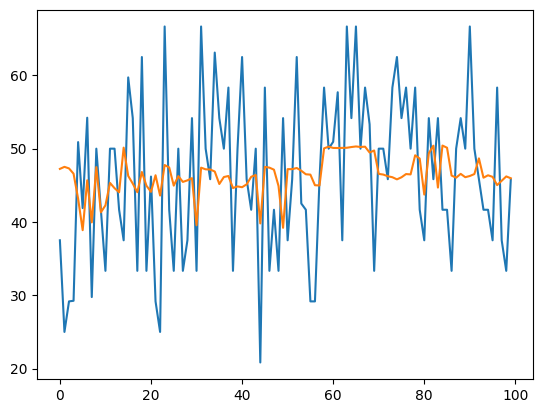

In [41]:
plt.plot(train_loss)
plt.plot(validation_loss)